## Problema de Negócio

A Rede de Drogarias Rossmann opera mais de 3.000 drogarias em 7 países europeus. Atualmente, os gerentes das lojas Rossmann são responsáveis por prever suas vendas diárias com até seis semanas de antecedência. As vendas das lojas são influenciadas por muitos fatores, incluindo promoções, competição, feriados escolares e estaduais, sazonalidade e localidade. Com milhares de gerentes individuais prevendo as vendas com base em suas circunstâncias únicas, a precisão dos resultados pode ser bastante variada.

Logo, nos foi solicitado a construção de um modelo preditivo de modo que tenhamos a previsão das vendas da sexta semanas das lojas, de modo que, essas previsões sejam padronizadas e, que os gerentes deleguem essa atividade para focarem, de fato, em gerenciar o orçamento e as ações baseado nesses previsões.

## 0.0 Pacotes e Bibliotecas

In [53]:
# Manipulação de Dados
import pandas as pd
import numpy  as np

# Visualização de Dados
from matplotlib import pyplot as plt
import seaborn as sbn
import xgboost as xgb
import lightgbm

from sklearn import pipeline, preprocessing, model_selection, compose, metrics, linear_model, tree, ensemble, svm

# Configurações
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
# Função para validação dos dados
def validacao_dados(dataset, nome_dataset):

    print(f'Validação dos Dados: {nome_dataset}')
    print(f'Quantidade de Linhas: {dataset.shape[0]}, Quantidade de Colunas: {dataset.shape[1]}.')

def metricas_validacao(y_real, y_predito):

    # Erro médio absoluto
    mae = metrics.mean_absolute_error(y_real, y_predito)

    # MAPE com tratamento para y_real = 0
    y_real = np.ravel(y_real)
    y_predito = np.ravel(y_predito)
    mask = y_real != 0
    if np.any(mask):
        mape = np.mean(np.abs((y_real[mask] - y_predito[mask]) / y_real[mask])) * 100
    else:
        mape = np.nan  # Ou defina um valor de fallback 

    # Erro médio quadrático
    rmse = metrics.root_mean_squared_error(y_real, y_predito)

    print(f'MAE: {mae:.2f}.')
    print(f'MAPE: {mape:.2f}')
    print(f'RMSE: {rmse:.2f}')

    # Retorno dos Valores
    return mae, mape, rmse

### 0.1 Dicionário de Dados

**Store**: Um identificador único para cada loja.

**Sales**: O faturamento de qualquer dia específico.

**Customers**: O número de clientes em um dado dia.

**Open**: Um indicador se a loja estava aberta: 0 = fechada, 1 = aberta.

**StateHoliday**: Indica um feriado estadual. Normalmente, todas as lojas, com poucas exceções, estão fechadas em feriados estaduais. Note que todas as escolas estão fechadas em feriados públicos e fins de semana. a = feriado público, b = feriado de Páscoa, c = Natal, 0 = Nenhum.

**SchoolHoliday**: Indica se a (Loja, Data) foi afetada pelo fechamento das escolas públicas.

**StoreType**: Diferencia entre 4 modelos de lojas diferentes: a, b, c, d.

**Assortment**: Descreve um nível de sortimento: a = básico, b = extra, c = estendido.

**CompetitionDistance**: Distância em metros até a loja concorrente mais próxima.

**CompetitionOpenSinceMonth/Year**: Dá o ano aproximado e o mês em que a loja concorrente mais próxima foi aberta.

**Promo**: Indica se uma loja está realizando uma promoção nesse dia.

**Promo2**: Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando.

**Promo2SinceYear/Month:** Descreve o ano e a semana do calendário em que a loja começou a participar da Promo2.

**PromoInterval**: Descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é reiniciada. Por exemplo, "Fev, Mai, Ago, Nov" significa que cada rodada começa em fevereiro, maio, agosto e novembro de qualquer ano para aquela loja.

## 1.0 Carregamento dos Dados

In [3]:
df1_fato = pd.read_csv('../BaseDados/DadosTreino.csv', delimiter=',', low_memory=False)
df1_dimensao = pd.read_csv('../BaseDados/DadosLoja.csv', delimiter=',', low_memory=False)

print('Validação dos Dados')
print(f'Fato -> Quantidade de Linhas: {df1_fato.shape[0]}, Quantidade de Colunas: {df1_fato.shape[1]}.')
print(f'Dimensão -> Quantidade de Linhas: {df1_dimensao.shape[0]}, Quantidade de Colunas: {df1_dimensao.shape[1]}.')

Validação dos Dados
Fato -> Quantidade de Linhas: 1017209, Quantidade de Colunas: 9.
Dimensão -> Quantidade de Linhas: 1115, Quantidade de Colunas: 10.


In [4]:
# Amostra dos Dados Dimensão
print('Amostra dos Dados Fato')
df1_fato.head(2)

Amostra dos Dados Fato


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [5]:
# Amostra dos Dados Dimensão
print('Amostra dos Dados Dimensão')
df1_dimensao.head(2)

Amostra dos Dados Dimensão


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"


Para que tenhamos um conjunto de dados completo, vamos fazer o junção entre a dimensão e a fato para trazer, para a fato, as informações da loja.

In [6]:
# Realização de um left join
df1 = df1_fato.merge(df1_dimensao, how='left', on='Store')

# Validação dos Dados
validacao_dados(df1, 'df1')

Validação dos Dados: df1
Quantidade de Linhas: 1017209, Quantidade de Colunas: 18.


### 1.1 Seleção dos Dados

Como o nosso objetivo é realizar a previsão das próximas 6 semanas de vendas das lojas, podemos, após um entendimento das variáveis, verificar quais delas fazem sentido. 

1. Nossa análise só faz sentido se as lojas estiverem abertas, sendo assim, vamos filtrar os dados e obter coma condição open = 1.
2. Ao analisar, temos que duas variávies não fazem sentido para nós. São elas: 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'.

Portanto, vmaos remover essas variáveis do nosso dataset e aplicar os filtros, de modo que, iniciemos nosso trabalho.

In [7]:
df1 = df1[df1['Open'] == 1].drop(columns=['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1).copy()

# Conferindo os dados
validacao_dados(df1, 'df1')

Validação dos Dados: df1
Quantidade de Linhas: 844392, Quantidade de Colunas: 15.


Com os dados consolidados, vamos iniciar.

## 2.0 Análise Exploratória dos Dados

In [8]:
# Cópia dos Dados
df2 = df1.copy()

# Validação dos Dados
validacao_dados(df2, 'df2')

Validação dos Dados: df2
Quantidade de Linhas: 844392, Quantidade de Colunas: 15.


### 2.1 Variável Alvo

Nossa variável alvo será as vendas das próximas 6 semanas de uma loja. Sendo assim, vamos precisar construir essa variável. Entretanto, para que faça sentido essa construção e, que os esforço que seram aplicados não sejam vazios, vamos realizar uma análise geral dos dados, inicialmente, para saber se, os dados em si, fazem sentido. Como, a variável 'Sales' é a que vai compor nossa variável alvo, vamos analisar o dataset tendo ela como alvo para saber se os dados fazem sentido.

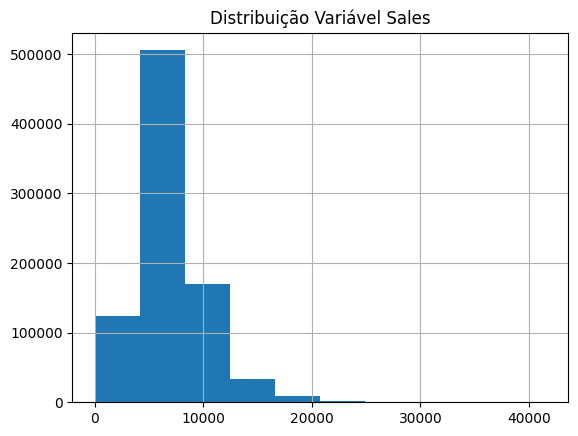

In [9]:
# Distribuição da variável Sales
df2['Sales'].hist()
plt.title('Distribuição Variável Sales');
plt.show();

Podemos ver uma distribuição a esquerda, o que nos diz que os temos muitas lojas que vendem, diariamente, até US$ 10.0000. Logo, não há uma distribuição normal. Inicialmente, não aplicaremos nenhuma função logarítimica. Seguiremos com os dados dessa forma, e caso seja necessário, tratamos os dados.

### 2.2 Resumo Estatístico

#### Variáveis Numéricas

In [10]:
# Obtenção das variáveis numéricas
df2_numerica = df2.select_dtypes(include=['int64', 'float64'])

# Resumo Estatístico
df2_numerica.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
count,844392.00,844392.00,844392.00,844392.00,844392.00,844392.00,844392.00,842206.00,575773.00,575773.00,844392.00
mean,558.42,3.52,6955.51,762.73,1.00,0.45,0.19,5457.98,7.22,2008.70,0.50
std,321.73,1.72,3104.21,401.23,0.00,0.50,0.40,7809.44,3.21,5.98,0.50
min,1.00,1.00,0.00,0.00,1.00,0.00,0.00,20.00,1.00,1900.00,0.00
25%,280.00,2.00,4859.00,519.00,1.00,0.00,0.00,710.00,4.00,2006.00,0.00
50%,558.00,3.00,6369.00,676.00,1.00,0.00,0.00,2320.00,8.00,2010.00,0.00
75%,837.00,5.00,8360.00,893.00,1.00,1.00,0.00,6890.00,10.00,2013.00,1.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00,75860.00,12.00,2015.00,1.00


**Relatório**

Podemos observar uma presença de dados nulos nas variáveis:
- Competition Distance
- Competition Open Since Month
- Competition Open Since Year
- Promo2

Além disso, podemos notar um presença de outliers nas variáveis 
- Sales
- Customers
- Competition Distance

##### Variáveis Categóricas

In [11]:
# Obtenção das variáveis categóricas
df2_categorica = df2.select_dtypes(exclude=['int64', 'float64'])

# Resumo Estatístico
df2_categorica.describe()

,Date,StateHoliday,StoreType,Assortment
count,844392,844392,844392,844392
unique,942,4,4,3
top,2015-06-30,0,a,a
freq,1115,843482,457077,444909


**Relatório**

Podemos ver que teremos bastante trabalho para limpar e tratar esses dados. Além disso, não podemos esquecer do nosso objetivo que é prever a vendas das lojas da rede rossmann nas próximas 6 semanas. Logo, para isso, vamos ter que, também construir nossa variável alvo.

Para que todo o nosso trabalho valha a pena, vamos realizar uma análise geral dos dados em relação a variável alvo 'sales'. Observe que essa variável é o insumo para que possamos construir nossa variável alvo, sendo assim, se os dados fizerem sentido de acordo com essa variável, então nossa construção de variável alvo estará bem embasada.

### 2.2 Análise Geral dos Dados

**Variáveis Numéricas**

Para que possamos ver se os dados fazem sentido, vamos obter as variáveis numéricas, no caso, são DayOfweek, Sales, Customers, CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear

In [12]:
# Definindo função para estudo de relaçaõ
def analise_pares(dados, variavel_dependente, variaveis_independentes, n):

    # Grupo de linhas com n gráficos por linha
    grupo_variaveis_independendentes = [variaveis_independentes[i:i+n] for i in range(0, len(variaveis_independentes), n)]

    # Loop pelos grupos de linhas para criar cada pair plot
    for grupo_variaveis in grupo_variaveis_independendentes:
        plot = sbn.pairplot(x_vars=grupo_variaveis, 
                            y_vars=variavel_dependente, 
                            data=dados, 
                            kind = "reg", 
                            height=5)

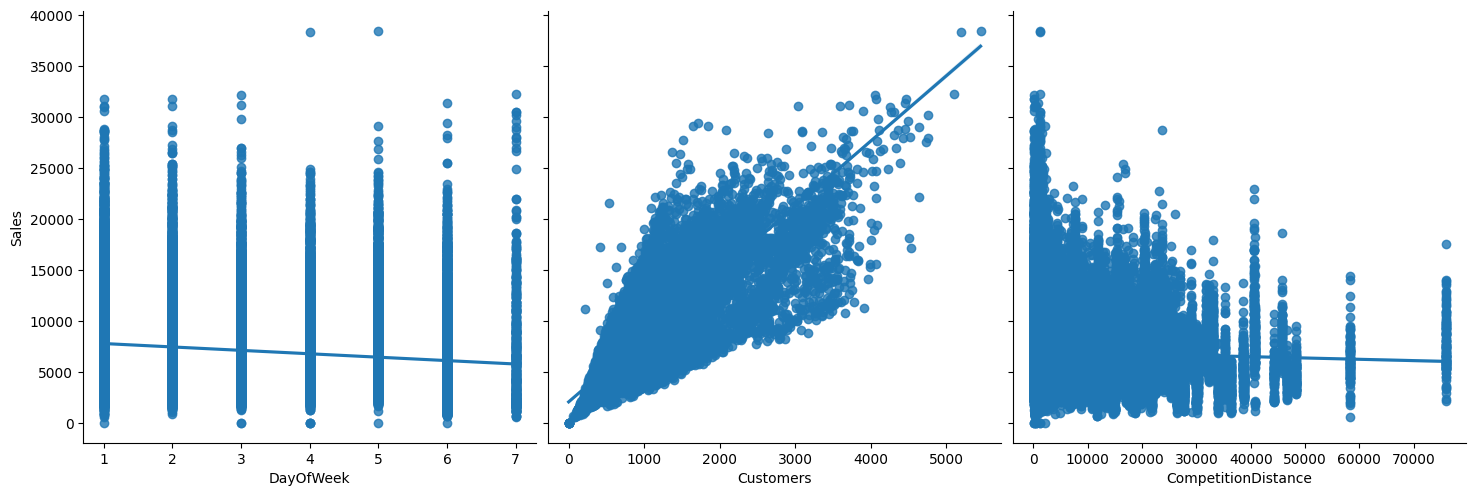

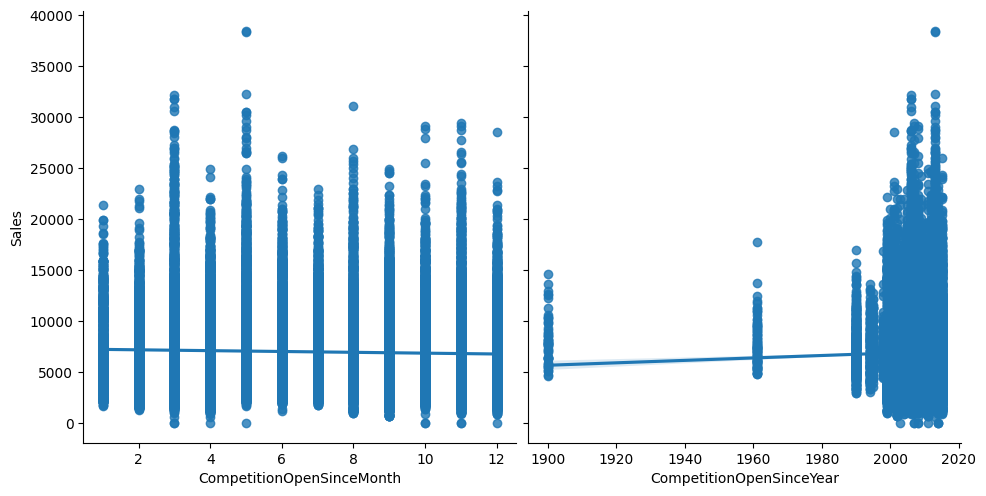

In [13]:
# Selecionando as variáveis numéricas
variaveis_independentes = ['DayOfWeek', 'Customers', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']
variavel_dependente = 'Sales'

# Realizando a Análise de pares
analise_pares(df2.sample(n=100000), variavel_dependente, variaveis_independentes, 3)

**Variáveis Categóricas**

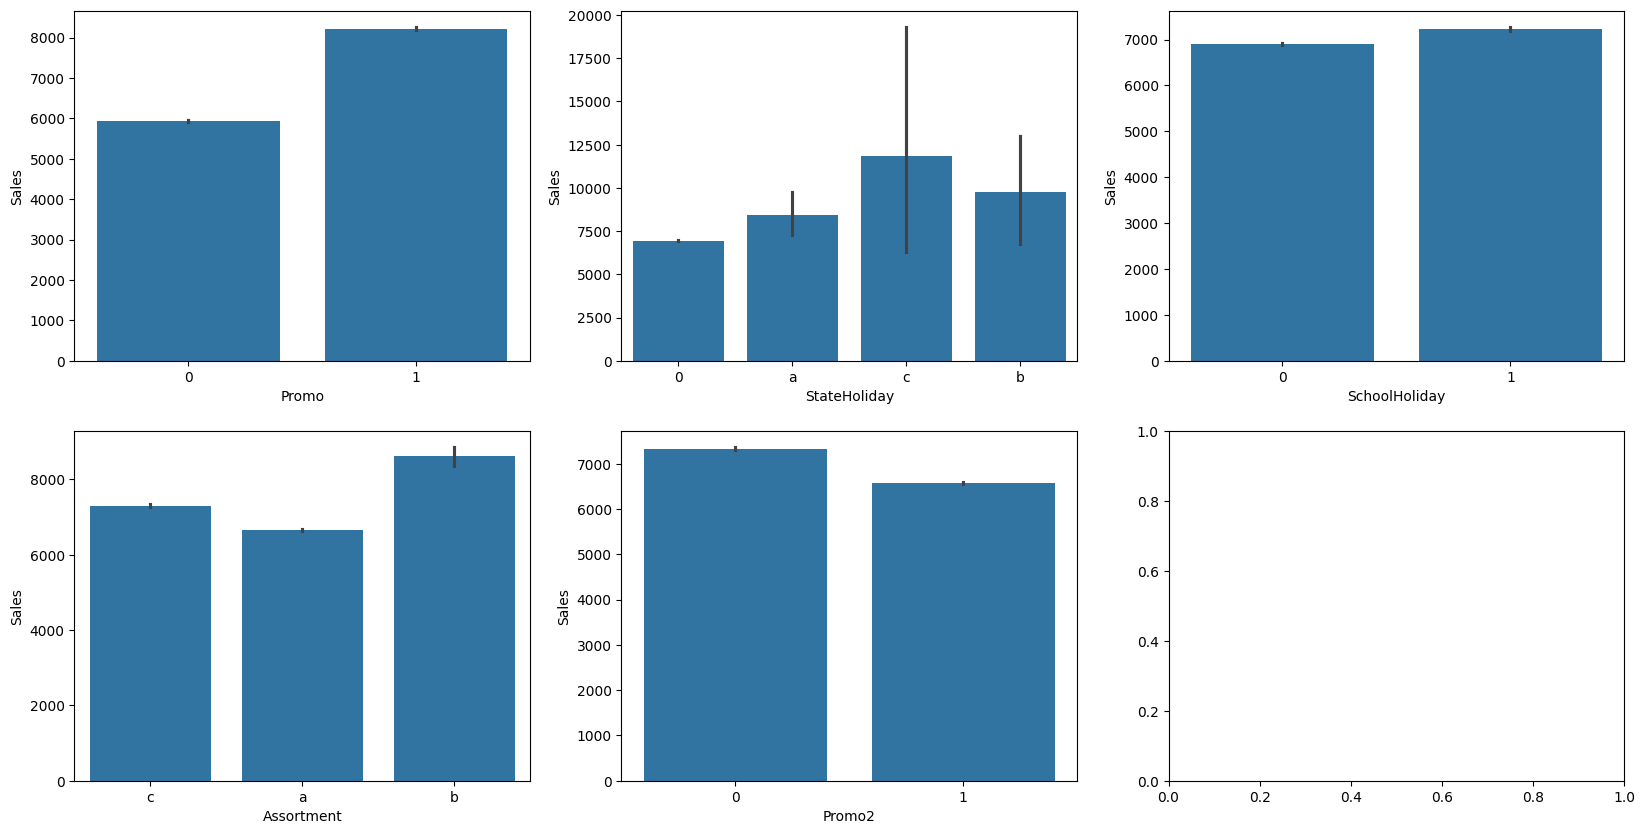

In [14]:
# Variável Promo
fig, axs = plt.subplots(2, 3, figsize=(20,10))
sbn.barplot(data=df2.sample(n=100000), x='Promo', y='Sales', ax=axs[0,0]);
sbn.barplot(data=df2.sample(n=100000), x='StateHoliday', y='Sales', ax=axs[0,1]);
sbn.barplot(data=df2.sample(n=100000), x='SchoolHoliday', y='Sales', ax=axs[0,2]);
sbn.barplot(data=df2.sample(n=100000), x='Assortment', y='Sales', ax=axs[1,0]);
sbn.barplot(data=df2.sample(n=100000), x='Promo2', y='Sales', ax=axs[1,1]);

**Relatório Final**

*DayOfWeek*: Ao analisar essa variável, podemos ver que a regressão apresenta uma tendência de queda no decorrer da semana. Naturalmente, se espera esse comportamento, pois aos finais de semanas se tem menos movimentos na cidade, inclusive em drogarias. Logo, o faturamento é menor. (Comportamento Esperado)

*Customers*: Claramente, quanto mais clientes em uma loja, maior é o faturamento dessa loja, pois existem mais pessoas comprando. (Comportamento Esperado)

*CompetitionDistance*: Podemos observar uma queda bem sucinta no faturamento com o aumento da distância. Uma possível explicação é que a falta de competitividade implica em menos ofertas e promoções. E, como sabemos, promoções impactam positivamente no faturamento. (Comportamento Esperado)

*CompetitionSinceMonth/Year: Ao analisar essas variáveis, podemos observar um comportamento anômalo de quando a competição começou. Podemos que existem lojas que a loja concorrente abriu em 1900, entretanto a Rossmann foi fundada em 1972. Logo, temos mais um tratamento a ser realizado. Se observamos os dados, existe uma leve subida da regressão. Isso indica que quanto mais recente é uma loja recente, maior é o faturamento. Veja que isso faz sentido, pois com lojas mais recentes abrindo, existem ofertas mais agressivas, logo, a Rossmann precisa responder a altura para que não ocorra tanta perca, sendo assim, fazendo ofertas que impactam no aumento do faturamento.

*Promo*: Loja que estão em promoção, possuem faturamento maior. (Comportamento Esperado)

*StateHoliday*: Aqui, temos um comportamento interessante. Vemos que o faturamento é maior na páscoa, natal e feriados públicos. Quando entendemos o modelo de negócio da rossmann, vemos que ela é considerada drogaria, mas ela também tem foco no varejo. Sendo assim, uma explicação para o aumento das vendas em feriados seja pelo fato da venda de alimentícios, comésticos e higienes como um todos, somado de ofertas agressivas.

*School Holidays*: Pelo mesmo motivo, podemos observar que em feriados escolares, as famílias tem motivos para realizar almoços, logo, gastando mais nas redes.

*Assortment*: Sabemos que quanto mais variedades escolhas, mais opções de compras podemos fazer. Quando temos poucas opções (a), isso faz com que não encontremos o que queremos, logo, deixamos de comprar, por outro lado, opções demais (c), não faz com que levemos mais itens. Logo, o meio termos (b) atende a maioria no geral, impactando em um faturamento maior.

*Promo2*: Uma promoção que se mantém em sequência tende a perder força, logo, impactando não tão positivamente no faturamento.


Resumo Final: No Geral, os dados fazem bastante sentido. Claramente, estamos utilizando aqui nossas habilidades de negócio, e referência do modelo de negócio da rossmann. Vamos seguir em nossa análise.

### 2.3 Tratamento dos Tipos de Dados

Para o nosso tratamento de dados, vamos trabalhar apenas no ajuste da variável Date. Vamos passá-la para datetime.

In [15]:
# Transformação de object para datetime
df2['Date'] = pd.to_datetime(df2['Date'], format='%Y-%m-%d')

### 2.4 Tratamento de Anomalias

Ao analisar nosso resumo estatístico de valores numéricos, podemos observar uma anomaila na variável CompetitionSinceYear, uma vez que a a menor data que temos é 1900 e, entretanto, a rede foi fundada em 1972. Vamos filtrar esses dados

In [16]:
print('Lojas com data de inicio de concorrência igual a 1900: {}'.format(df2[df2['CompetitionOpenSinceYear'] == 1900]['Store'].unique()))

# Dados relacionados a 1900.
df2[df2['CompetitionOpenSinceYear'] == 1900]


Lojas com data de inicio de concorrência igual a 1900: [815]


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
814,815,5,2015-07-31,8186,729,1,1,0,0,a,a,590.00,1.00,1900.00,1
1929,815,4,2015-07-30,7983,666,1,1,0,0,a,a,590.00,1.00,1900.00,1
3044,815,3,2015-07-29,6604,583,1,1,0,0,a,a,590.00,1.00,1900.00,1
4159,815,2,2015-07-28,7908,680,1,1,0,0,a,a,590.00,1.00,1900.00,1
5274,815,1,2015-07-27,8201,712,1,1,0,0,a,a,590.00,1.00,1900.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010219,815,1,2013-01-07,12868,1161,1,1,0,0,a,a,590.00,1.00,1900.00,1
1012449,815,6,2013-01-05,7843,767,1,0,0,0,a,a,590.00,1.00,1900.00,1
1013564,815,5,2013-01-04,8210,825,1,0,0,1,a,a,590.00,1.00,1900.00,1
1014679,815,4,2013-01-03,8059,828,1,0,0,1,a,a,590.00,1.00,1900.00,1


Podemos ver que é apenas uma loja, logo, talvez tenhamos algum erro de dígito. Sendo assim, vamos substituir a o ano de abertura pela menor data de vendas.

In [17]:
# Tratativa da Data
df2.loc[df2[df2['Store'] == 815].index.tolist(), 'CompetitionOpenSinceYear'] = df2[df2['Store'] == 815]['Date'].min().year

Uma vez tratado, vamos novamente ver o nosso resumo estatístico

In [18]:
# Obtenção das variáveis numéricas
df2_numerica = df2.select_dtypes(include=['int64', 'float64'])

# Resumo Estatístico
df2_numerica.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
count,844392.00,844392.00,844392.00,844392.00,844392.00,844392.00,844392.00,842206.00,575773.00,575773.00,844392.00
mean,558.42,3.52,6955.51,762.73,1.00,0.45,0.19,5457.98,7.22,2008.82,0.50
std,321.73,1.72,3104.21,401.23,0.00,0.50,0.40,7809.44,3.21,4.79,0.50
min,1.00,1.00,0.00,0.00,1.00,0.00,0.00,20.00,1.00,1961.00,0.00
25%,280.00,2.00,4859.00,519.00,1.00,0.00,0.00,710.00,4.00,2006.00,0.00
50%,558.00,3.00,6369.00,676.00,1.00,0.00,0.00,2320.00,8.00,2010.00,0.00
75%,837.00,5.00,8360.00,893.00,1.00,1.00,0.00,6890.00,10.00,2013.00,1.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00,75860.00,12.00,2015.00,1.00


Com a anomalia removida, vamos para a nossa próxima etapa, que no caso, é o tratamento de dados nulos.

### 2.5 Tratamento de Dados Nulos

In [19]:
# Quantidade de Dados Nulos
print(f'Variáveis e as suas quantidade de dados nulos: \n{df2.isna().sum()[df2.isna().sum()> 0]}')

Variáveis e as suas quantidade de dados nulos: 
CompetitionDistance            2186
CompetitionOpenSinceMonth    268619
CompetitionOpenSinceYear     268619
dtype: int64


Vamos analisar mais afundo essas variáveis e entender como podemos tratar esses dados nulos. 

**Competition Distance**

In [20]:
# Analisando os dados nulos da variável Competition Distance
df2[df2['CompetitionDistance'].isna()].sort_values(by=['Store', 'Date'], ascending=True)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
1015270,291,3,2013-01-02,7658,876,1,0,0,1,d,a,NaN,NaN,NaN,0
1014155,291,4,2013-01-03,7285,871,1,0,0,0,d,a,NaN,NaN,NaN,0
1013040,291,5,2013-01-04,7687,920,1,0,0,0,d,a,NaN,NaN,NaN,0
1011925,291,6,2013-01-05,5316,552,1,0,0,0,d,a,NaN,NaN,NaN,0
1009695,291,1,2013-01-07,13080,1316,1,1,0,0,d,a,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5338,879,1,2015-07-27,5884,427,1,1,0,0,d,a,NaN,NaN,NaN,1
4223,879,2,2015-07-28,5320,389,1,1,0,0,d,a,NaN,NaN,NaN,1
3108,879,3,2015-07-29,5129,362,1,1,0,0,d,a,NaN,NaN,NaN,1
1993,879,4,2015-07-30,5861,426,1,1,0,0,d,a,NaN,NaN,NaN,1


Dada a baixa volumetria desses dados nulos e a sua natureza, vamos eliminá-los. Esses dados nulos podem ser dados por duas situações:

1. Erro de inserções de dados. Necessário entender com os responsáveis.
2. Concorrente está tão longe da loja, que se optou por não inserir informações. 

Seria necessário sentar com a área de dados e entender esses detalhes.

In [21]:
# Eliminando os dados em que o competition distance é nulo
df2 = df2.drop(index=df2[df2['CompetitionDistance'].isna()].sort_values(by=['Store', 'Date'], ascending=True).index.tolist())

# Validação dos Dados
validacao_dados(df2,'df2')

Validação dos Dados: df2
Quantidade de Linhas: 842206, Quantidade de Colunas: 15.


In [22]:
# Validação dos Dados Nulos
df2.isna().sum()[df2.isna().sum() > 0]

CompetitionOpenSinceMonth    266433
CompetitionOpenSinceYear     266433
dtype: int64

**Competition Open Since Year**

Vamos analisar os dados nulos dessa variável

In [23]:
# Obtenção dos Dados
df2[df2['CompetitionOpenSinceYear'].isna()].sample(n=10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
633049,515,3,2013-12-11,8155,695,1,0,0,0,d,c,11260.00,NaN,NaN,1
826787,243,4,2013-06-20,5772,806,1,1,0,0,a,a,310.00,NaN,NaN,1
392748,271,4,2014-07-17,9133,975,1,1,0,0,a,a,420.00,NaN,NaN,1
639641,417,4,2013-12-05,9898,923,1,1,0,0,a,c,840.00,NaN,NaN,1
451987,83,4,2014-05-22,3862,336,1,1,0,0,a,a,2710.00,NaN,NaN,0
300983,105,4,2014-10-23,4191,630,1,1,0,0,a,c,6190.00,NaN,NaN,1
404240,591,6,2014-07-05,4164,334,1,0,0,0,a,c,3340.00,NaN,NaN,1
787291,887,5,2013-07-26,6210,560,1,0,0,1,d,a,19700.00,NaN,NaN,1
274688,1083,5,2014-11-21,5201,378,1,0,0,0,d,c,11540.00,NaN,NaN,1
852542,353,2,2013-05-28,4473,1227,1,1,0,1,b,b,900.00,NaN,NaN,1


Observe que, ao analisar esses dados nulos, vemos que temos a informação de concorrentes que estamos a uma certa distância, todavia, não há informações de qual ano essa concorrente iniciou. Sendo assim, vamos assumir que a data mais antiga de compra é quando esse cliente iniciou. Observe que, aqui, é necessário tratar de fato, pois o volume dados nulos é bem grande.

In [24]:
# Obtendo a menor data de vendas em relação a cada loja.
competition_date = df2[['Store', 'Date']].groupby('Store').min().reset_index()

# Vamos extrair o anoa dessas datas
competition_date['MinDate'] =  competition_date['Date'].apply(lambda x: x.year)

# Eliminando colunas desnecessárias
competition_date = competition_date.drop(columns=['Date'], axis=1)

# Aplicação de um left join para preencher os dados nulos
df2 = df2.merge(competition_date, how='left', on='Store')

# Eliminando os Dados Nulos dos Anos
df2['CompetitionOpenSinceYear'] = np.where(df2['CompetitionOpenSinceYear'].isna(), df2['MinDate'], df2['CompetitionOpenSinceYear'])

# Validação
print(f'Quantidade de Dados Nulos: \n{df2.isna().sum()[df2.isna().sum() > 0]}')

Quantidade de Dados Nulos: 
CompetitionOpenSinceMonth    266433
dtype: int64


**Competition Open Since Month**

Idem a ideia da variável anterior

In [25]:
# Obtendo a menor data de vendas em relação a cada loja.
competition_date = df2[['Store', 'Date']].groupby('Store').min().reset_index()

# Vamos extrair o anoa dessas datas
competition_date['MinMonth'] =  competition_date['Date'].apply(lambda x: x.month)

# Eliminando colunas desnecessárias
competition_date = competition_date.drop(columns=['Date'], axis=1)

# Aplicação de um left join para preencher os dados nulos
df2 = df2.merge(competition_date, how='left', on='Store')

# Eliminando os Dados Nulos dos Anos
df2['CompetitionOpenSinceMonth'] = np.where(df2['CompetitionOpenSinceMonth'].isna(), df2['MinDate'], df2['CompetitionOpenSinceMonth'])

# Validação
print(f'Quantidade de Dados Nulos: \n{df2.isna().sum()[df2.isna().sum() > 0]}')

Quantidade de Dados Nulos: 
Series([], dtype: int64)


In [26]:
# Dropando as colunas desnecessárias
df2 = df2.drop(columns=['MinMonth', 'MinDate'], axis=1)

Com os dados devidamente tratados, podemos ir para a nossa próxima etapa, que é, o tratamento de Outliers.

### 2.5 Tratamento de Outliers

Dado nosso problema de negócio e as nossas variáveis, faz sentido analisarmos as seguintes variáveis:
* Sales
* Customers
* CompetitionDistance

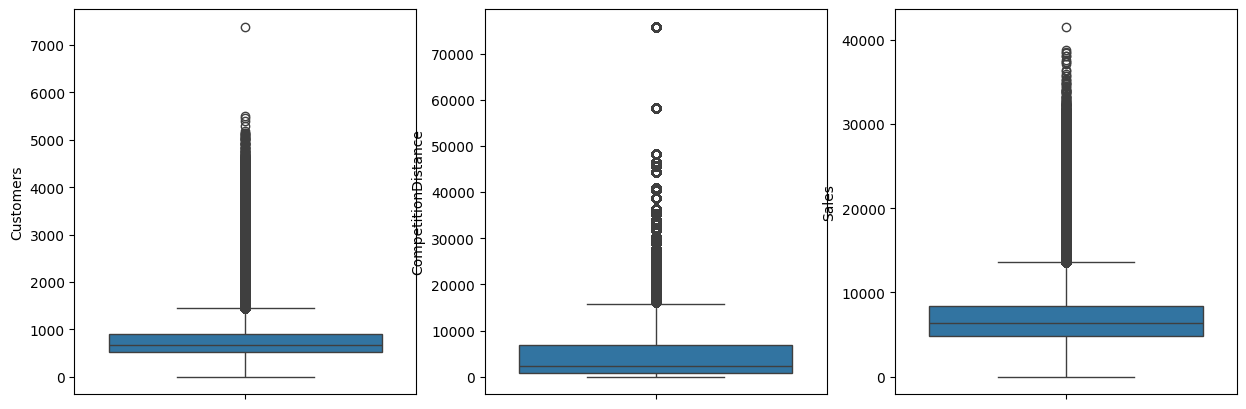

In [27]:
# Plotando Gráficos
fig, ax = plt.subplots(1, 3, figsize=(15,5))
sbn.boxplot(data=df2, y='Customers', ax=ax[0]);
sbn.boxplot(data=df2, y='CompetitionDistance', ax=ax[1]);
sbn.boxplot(data=df2, y='Sales', ax=ax[2]);

Observe que temos a presença de muitos outliers nos nossos dados. Entretanto, precisamos entender que esses outliers não são anomalias, mas sim, características naturais dos dados.
Logo, não é recomendado que nós deletemos eles, entretanto, cogitemos modelos que consigam superar esses outliers.

In [28]:
# Resumo Estatístico Final
df2.select_dtypes(include=['int64', 'float64']).describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
count,842206.00,842206.00,842206.00,842206.00,842206.00,842206.00,842206.00,842206.00,842206.00,842206.00,842206.00
mean,558.37,3.52,6959.34,763.27,1.00,0.45,0.19,5457.98,641.75,2010.14,0.50
std,321.92,1.72,3104.46,401.38,0.00,0.50,0.40,7809.44,932.79,4.41,0.50
min,1.00,1.00,0.00,0.00,1.00,0.00,0.00,20.00,1.00,1961.00,0.00
25%,280.00,2.00,4864.00,519.00,1.00,0.00,0.00,710.00,6.00,2008.00,0.00
50%,557.00,3.00,6373.00,676.00,1.00,0.00,0.00,2320.00,10.00,2012.00,0.00
75%,837.00,5.00,8363.00,893.00,1.00,1.00,0.00,6890.00,2013.00,2013.00,1.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00,75860.00,2013.00,2015.00,1.00


Portanto, com os dados consolidados, tratados e limpos, podemos ir para a próxima etapa.

## 3.0 Engenharia de Atributos

O objetivo dessa etapa é conseguir ver a possibilidade de informações que estão 'escondidas' nos dados. Podemos obervar que o nosso dataset é bem limitado, sendo assim, vamos inicialmente construir nossa variável que é as vendas dos próximos 6 dias.

In [29]:
# Cópia dos Dados
df3 = df2.copy()

# Ordenamento dos Dados
df3_sort = df3.sort_values(by=['Store', 'Date'], ascending=True).reset_index(drop=True).copy()

# Amostra dos Dados
df3_sort.head()

print(df3_sort.shape)

(842206, 15)


Observe que a variável stateHolyday é uma variável categórica, vamos criar variáveis dummies de modo trazer essas variáveis.

In [30]:
# Gerando as variáveis dummies para os feriados
df3_sort = (pd.get_dummies(data=df3_sort, columns=['StateHoliday'], dtype=np.int64)
              .drop(columns=['StateHoliday_0', 'StateHoliday_b', 'StateHoliday_c'], axis=1)
              .rename(columns={'StateHoliday_a':'PublicHoliday', 'StateHoliday_b':'EasterHoliday', 'StateHoliday_c':'Christmas_Holiday'}))

print(df3_sort.shape)

# Amostra dos resultados
df3_sort.head()

(842206, 15)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,PublicHoliday
0,1,3,2013-01-02,5530,668,1,0,1,c,a,1270.00,9.00,2008.00,0,0
1,1,4,2013-01-03,4327,578,1,0,1,c,a,1270.00,9.00,2008.00,0,0
2,1,5,2013-01-04,4486,619,1,0,1,c,a,1270.00,9.00,2008.00,0,0
3,1,6,2013-01-05,4997,635,1,0,1,c,a,1270.00,9.00,2008.00,0,0
4,1,1,2013-01-07,7176,785,1,1,1,c,a,1270.00,9.00,2008.00,0,0


In [31]:
# Vendas do último dia
df3_sort['SalesLastDay'] = df3_sort.groupby('Store')['Sales'].shift(1)

# Média dos últimos 7 dias
df3_sort['MeanSalesLastSevenDays'] = df3_sort.groupby('Store')['Sales'].shift(1).rolling(7).mean()

# Total de vendas dos últimos 7 dias
df3_sort['TotalSalesLastSevenDays'] = df3_sort.groupby('Store')['Sales'].shift(1).rolling(7).sum()

# Total de Promoções aplicadas nos últimos 7 dias
df3_sort['TotalPromoLastSevenDays'] = df3_sort.groupby('Store')['Promo'].shift(1).rolling(7).sum()

# Total de Feriados Públicos nos últimos 7 dias
df3_sort['TotalPublicHolidaysLastSevenDays'] = df3_sort.groupby('Store')['PublicHoliday'].shift(1).rolling(7).sum()

# Total de promoções 2 ativadas nos últimos 7 dias
df3_sort['TotalPromo2LastSevenDays'] = df3_sort.groupby('Store')['Promo2'].shift(1).rolling(7).sum()

# Total de feriados escolares no últimos 7 dias
df3_sort['TotalSchoolHolidayLastSevenDays'] = df3_sort.groupby('Store')['SchoolHoliday'].shift(1).rolling(7).sum()

# Anos de Competição
df3_sort['YearsCompetition'] = df3_sort['Date'].max().year - df3_sort['CompetitionOpenSinceYear']

# Construção da nossa variável alvo
df3_sort['TotalSalesNextSixDays'] = (
    pd.concat([
        df3_sort.groupby('Store')['Sales'].shift(-i)
        for i in range(1, 7)
    ], axis=1)
    .sum(axis=1, min_count=6)
)

print('Dimensão dos Dados : {}'.format(df3_sort.shape))

Dimensão dos Dados : (842206, 24)


Aqui vamos selecionar apenas as variáveis que façam sentido para o nosso problema. 

In [32]:
df3_sort = df3_sort[['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'YearsCompetition', 'Sales', 'Customers', 'Promo','Promo2', 'PublicHoliday', 'SalesLastDay',
                     'MeanSalesLastSevenDays', 'TotalSalesLastSevenDays', 'TotalPromoLastSevenDays', 'TotalPromo2LastSevenDays', 'TotalSchoolHolidayLastSevenDays', 'TotalPublicHolidaysLastSevenDays',
                     'TotalSalesNextSixDays']]

# Renomeando colunas
df3_sort = df3_sort.rename(columns={'Sales':'SalesDay', 'Customers': 'CustomersDay', 'PromoDay':'Promo2Day', 'PublicHoliday':'PublicHolidayDay'})

Observe que a nossa variável alvo nossa é a TotalSalesNextSixDays. Sendo assim, nossa variável alvo não pode ser nula. Além disso, de modo que tenhamos o máximo de informação consolidada, vamos eliminar a quantidade as variáveis nulas em relação a soma móveis, pois pelo fato de ser nulo, quer dizer que não há informações disponíveis, logo, não está trazendo o conteúdo que precisamos.

In [33]:
# Validação dos dados antes da eliminação
validacao_dados(df3_sort, 'Dataset Ordenado')

# eliminando os dados desnecessários
df3_sort_clean = df3_sort.dropna()

# Validacao dos Dados
validacao_dados(df3_sort_clean, 'Dataset Ordenado e Limpo')

df3_sort_clean.head()

Validação dos Dados: Dataset Ordenado
Quantidade de Linhas: 842206, Quantidade de Colunas: 18.
Validação dos Dados: Dataset Ordenado e Limpo
Quantidade de Linhas: 827750, Quantidade de Colunas: 18.


,Store,StoreType,Assortment,CompetitionDistance,YearsCompetition,SalesDay,CustomersDay,Promo,Promo2,PublicHolidayDay,SalesLastDay,MeanSalesLastSevenDays,TotalSalesLastSevenDays,TotalPromoLastSevenDays,TotalPromo2LastSevenDays,TotalSchoolHolidayLastSevenDays,TotalPublicHolidaysLastSevenDays,TotalSalesNextSixDays
7,1,c,a,1270.00,7.00,4892,615,1,0,0,5471.00,5366.71,37567.00,3.00,0.00,7.00,0.00,26502.00
8,1,c,a,1270.00,7.00,4881,592,1,0,0,4892.00,5275.57,36929.00,4.00,0.00,7.00,0.00,25748.00
9,1,c,a,1270.00,7.00,4952,646,0,0,0,4881.00,5354.71,37483.00,5.00,0.00,7.00,0.00,25978.00
10,1,c,a,1270.00,7.00,4717,616,0,0,0,4952.00,5421.29,37949.00,5.00,0.00,6.00,0.00,26655.00
11,1,c,a,1270.00,7.00,3900,512,0,0,0,4717.00,5381.29,37669.00,5.00,0.00,5.00,0.00,28475.00


Como os dados devidamente tratados e limpos e com as base consolidadas, vamos iniciar a fase de separação dos dados em treino, teste e validação e pré-processamento dos dados.

## 4.0 Separação dos Dados em Treino, Validação e Teste

In [34]:
# Cópia dos dados
df4 = df3_sort_clean.copy()

validacao_dados(df4, 'df4')

Validação dos Dados: df4
Quantidade de Linhas: 827750, Quantidade de Colunas: 18.


In [35]:
# Variáveis Independentes
X = df4.drop(columns=['TotalSalesNextSixDays', 'Store'])
y = df4[['TotalSalesNextSixDays']]

# Obtendo os dados de treino
X_treino, X_transacional, y_treino, y_transacional = model_selection.train_test_split(X, y, train_size=0.7)

print('\nDados de Treino')
validacao_dados(X_treino, 'X_treino')
validacao_dados(y_treino, 'y_treino')

# Obtendo os dados de validação e teste
X_validacao, X_teste, y_validacao, y_teste = model_selection.train_test_split(X_transacional, y_transacional, train_size=0.5)

print('\nDados de Validação')
validacao_dados(X_validacao, 'X Validacao')
validacao_dados(y_validacao, 'y Validacao')

print('\nDados de Teste')
validacao_dados(X_teste, 'X Teste')
validacao_dados(y_teste, 'y Teste')


Dados de Treino
Validação dos Dados: X_treino
Quantidade de Linhas: 579425, Quantidade de Colunas: 16.
Validação dos Dados: y_treino
Quantidade de Linhas: 579425, Quantidade de Colunas: 1.

Dados de Validação
Validação dos Dados: X Validacao
Quantidade de Linhas: 124162, Quantidade de Colunas: 16.
Validação dos Dados: y Validacao
Quantidade de Linhas: 124162, Quantidade de Colunas: 1.

Dados de Teste
Validação dos Dados: X Teste
Quantidade de Linhas: 124163, Quantidade de Colunas: 16.
Validação dos Dados: y Teste
Quantidade de Linhas: 124163, Quantidade de Colunas: 1.


## 5.0 Pré-Processamento dos Dados

De modo a termos um processo mais integro e menos passível de erro, vamos utilizar o método pipeline.

In [36]:
# Colunas Numéricas
numeric_columns = X_treino.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Colunas Categóricas
dummies_columns = ['StoreType']
ordinal_columns = ['Assortment']

# Construção do Pipeline para transformar variáveis numéricas
num_transformer = pipeline.Pipeline( [ ('scaler', preprocessing.StandardScaler() ) ] )

# Construção do Pipeline para criar as variáveis dummies
dummies_transformer = pipeline.Pipeline( [ ('one-hot', preprocessing.OneHotEncoder(handle_unknown='ignore', dtype=np.int64) ) ] )

# Construção do Pipeline para criar o encoding ordenado
ordinal_transformer = pipeline.Pipeline( [ ( 'ordinal', preprocessing.OrdinalEncoder( categories=[['a', 'b', 'c']], handle_unknown='use_encoded_value', unknown_value=-1) ) ] )

Vamos construir nosso método para transformar as colunas

In [37]:
# Construção do pré-processamento
pre_processamento = compose.ColumnTransformer(transformers=[('num_columns', num_transformer, numeric_columns),
                                                            ('dummies_columns', dummies_transformer, dummies_columns),
                                                            ('ordinal_columns', ordinal_transformer , ordinal_columns)])

In [38]:
# Validação do pré-processamento
validacao_pre_processamento = pre_processamento.fit(X_treino)

Vamos para a fase de modelagem

## 6.0 Treinamento do Modelo

Durante o todo processo, percebemos a presença de outliers, o que já era esperado, pois claramente existiram lojas que vão vender mais do que outras dada o seu tamanho e localidade. Sendo assim, utilizar modelos menos complexos, como um regressão simples, por exemplo, nos mostrará um performance bem ruim. Entretanto, eles servem de referência para saber se estamos melhorando ou não. Além disso, também não optamos por fazer um processo de seleção de colunas. Nesse momento, vamos implementar todas as variáveis e, a partir disso, verificar a performance dos nossos modelos.

### 6.1 Regressão Simples

In [39]:
# Instanciando e criando pipeline para o modelo de regressão simples
pipe_regressao = pipeline.Pipeline(steps=[('Pré - Processamento', pre_processamento),
                                          ('Regressão Simples', linear_model.LinearRegression())])

# Treinamento do modelo
pipe_regressao.fit(X_treino, y_treino)

# Predição do Modelo - Aprendizado
y_regressao_aprendizado = pipe_regressao.predict(X_treino)

# Métricas de Validação - capacidade de Aprendizado
print('================ Capacidade de Aprendizado ================ ')
mae_aprendizado_regressao, mape_aprendizado_regressao, rmse_aprendizado_regressao = metricas_validacao(y_treino, y_regressao_aprendizado) 

# Predição do Modelo - Generalização
y_regressao_generalizacao = pipe_regressao.predict(X_validacao)

print('\n================ Capacidade de Generalização ================')
mae_generalizacao_regressao, mape_generalizacao_regressao, rmse_generalizacao_regressao = metricas_validacao(y_validacao, y_regressao_generalizacao) 

================ Capacidade de Aprendizado ================ 
MAE: 4854.98.
MAPE: 11.95
RMSE: 6674.18

================ Capacidade de Generalização ================
MAE: 4864.03.
MAPE: 11.96
RMSE: 6679.47


### 6.2 Regressão Simples - Penalidade Ridge

Quando analisamos a aplicação da regressão linear no ciclo2 para o ciclo3, podemos observar uma melhora muito significativa, saindo de um MAE de 20% para um MAE, agora de 11%. Vamos ver se, mudando a penalidade sobre o erro, na regressão, ocorre uma melhoria.

In [40]:
# Instanciando e criando pipeline para o modelo de ridge
pipe_ridge = pipeline.Pipeline(steps=[('Pré - Processamento', pre_processamento),
                                      ('Ridge', linear_model.Ridge())])

# Treinamento do modelo
pipe_ridge.fit(X_treino, y_treino)

# Predição do Modelo - Aprendizado
y_ridge_aprendizado = pipe_ridge.predict(X_treino)

# Métricas de Validação - capacidade de Aprendizado
print('================ Capacidade de Aprendizado ================ ')
mae_aprendizado_ridge, mape_aprendizado_ridge, rmse_aprendizado_ridge = metricas_validacao(y_treino, y_ridge_aprendizado) 

# Predição do Modelo - Generalização
y_ridge_generalizacao = pipe_ridge.predict(X_validacao)

print('\n================ Capacidade de Generalização ================')
mae_generalizacao_ridge, mape_generalizacao_ridge, rmse_generalizacao_ridge = metricas_validacao(y_validacao, y_ridge_generalizacao) 

================ Capacidade de Aprendizado ================ 
MAE: 4854.98.
MAPE: 11.95
RMSE: 6674.18

================ Capacidade de Generalização ================
MAE: 4864.03.
MAPE: 11.96
RMSE: 6679.47


### 6.3 Regressão Simples - Penalidade Lasso

In [41]:
# Instanciando e criando pipeline para o modelo de lasso
pipe_lasso = pipeline.Pipeline(steps=[('Pré - Processamento', pre_processamento),
                                      ('Lasso', linear_model.Lasso())])

# Treinamento do modelo
pipe_lasso.fit(X_treino, y_treino)

# Predição do Modelo - Aprendizado
y_lasso_aprendizado = pipe_lasso.predict(X_treino)

# Métricas de Validação - capacidade de Aprendizado
print('================ Capacidade de Aprendizado ================ ')
mae_aprendizado_lasso, mape_aprendizado_lasso, rmse_aprendizado_lasso = metricas_validacao(y_treino, y_lasso_aprendizado) 

# Predição do Modelo - Generalização
y_lasso_generalizacao = pipe_lasso.predict(X_validacao)

print('\n================ Capacidade de Generalização ================')
mae_generalizacao_lasso, mape_generalizacao_lasso, rmse_generalizacao_lasso = metricas_validacao(y_validacao, y_lasso_generalizacao) 

================ Capacidade de Aprendizado ================ 
MAE: 4854.81.
MAPE: 11.95
RMSE: 6674.19

================ Capacidade de Generalização ================
MAE: 4863.87.
MAPE: 11.96
RMSE: 6679.51


**Observação:** Podemos observar que aplicando a regressão linear com a mudança de penalidade sobre os erros, não obtive, nem melhorias e nem pioras significativas, sendo assim, vamos evoluir para modelos mais complexos. Sabendo da presença de outliers, vamos iniciar nosso aprofundamento indo para modelos de árvore.

### 6.4 Tree Regressor

In [42]:
# Instanciando e criando pipeline para o modelo de tree
pipe_tree = pipeline.Pipeline(steps=[('Pré - Processamento', pre_processamento),
                                      ('Tree', tree.DecisionTreeRegressor(max_depth=5))])

# Treinamento do modelo
pipe_tree.fit(X_treino, y_treino)

# Predição do Modelo - Aprendizado
y_tree_aprendizado = pipe_tree.predict(X_treino)

# Métricas de Validação - capacidade de Aprendizado
print('================ Capacidade de Aprendizado ================ ')
mae_aprendizado_tree, mape_aprendizado_tree, rmse_aprendizado_tree = metricas_validacao(y_treino, y_tree_aprendizado) 

# Predição do Modelo - Generalização
y_tree_generalizacao = pipe_tree.predict(X_validacao)

print('\n================ Capacidade de Generalização ================')
mae_generalizacao_tree, mape_generalizacao_tree, rmse_generalizacao_tree = metricas_validacao(y_validacao, y_tree_generalizacao)

================ Capacidade de Aprendizado ================ 
MAE: 5695.37.
MAPE: 14.19
RMSE: 7655.49

================ Capacidade de Generalização ================
MAE: 5713.94.
MAPE: 14.22
RMSE: 7675.71


### 6.5 ExtraTree

In [43]:
# Instanciando e criando pipeline para o modelo de extree
pipe_extree = pipeline.Pipeline(steps=[('Pré - Processamento', pre_processamento),
                                      ('ExtraTree', tree.ExtraTreeRegressor(max_depth=5))])

# Treinamento do modelo
pipe_extree.fit(X_treino, y_treino)

# Predição do Modelo - Aprendizado
y_extree_aprendizado = pipe_extree.predict(X_treino)

# Métricas de Validação - capacidade de Aprendizado
print('================ Capacidade de Aprendizado ================ ')
mae_aprendizado_extree, mape_aprendizado_extree, rmse_aprendizado_extree = metricas_validacao(y_treino, y_extree_aprendizado) 

# Predição do Modelo - Generalização
y_extree_generalizacao = pipe_extree.predict(X_validacao)

print('\n================ Capacidade de Generalização ================')
mae_generalizacao_extree, mape_generalizacao_extree, rmse_generalizacao_extree = metricas_validacao(y_validacao, y_extree_generalizacao) 

================ Capacidade de Aprendizado ================ 
MAE: 6119.48.
MAPE: 15.22
RMSE: 8234.75

================ Capacidade de Generalização ================
MAE: 6146.78.
MAPE: 15.28
RMSE: 8263.84


Podemos observar que as árvores obtiveram uma performance um pouco pior. Sendo assim, sabendo que a regressão teve uma performance até considerável, vamos utilizar o método SVM que suportam e lidam bem com outliers

### 6.6 LinearSVR

In [44]:
# Instanciando e criando pipeline para o modelo de svr
pipe_lsvr = pipeline.Pipeline(steps=[('Pré - Processamento', pre_processamento),
                                      ('SVR', svm.LinearSVR(max_iter=100))])

# Treinamento do modelo
pipe_lsvr.fit(X_treino, np.ravel(y_treino))

# Predição do Modelo - Aprendizado
y_lsvr_aprendizado = pipe_lsvr.predict(X_treino)

# Métricas de Validação - capacidade de Aprendizado
print('================ Capacidade de Aprendizado ================ ')
mae_aprendizado_lsvr, mape_aprendizado_lsvr, rmse_aprendizado_lsvr = metricas_validacao(y_treino, y_lsvr_aprendizado) 

# Predição do Modelo - Generalização
y_lsvr_generalizacao = pipe_lsvr.predict(X_validacao)

print('\n================ Capacidade de Generalização ================')
mae_generalizacao_lsvr, mape_generalizacao_lsvr, rmse_generalizacao_lsvr = metricas_validacao(y_validacao, y_lsvr_generalizacao) 

================ Capacidade de Aprendizado ================ 
MAE: 4824.96.
MAPE: 11.51
RMSE: 6807.52

================ Capacidade de Generalização ================
MAE: 4834.94.
MAPE: 11.52
RMSE: 6818.81


### 6.7 ExtraTreesRegressor

In [45]:
# Instanciando e criando pipeline para o modelo de svr
pipe_extrees = pipeline.Pipeline(steps=[('Pré - Processamento', pre_processamento),
                                      ('SVR', ensemble.ExtraTreesRegressor(max_depth=5))])

# Treinamento do modelo
pipe_extrees.fit(X_treino, np.ravel(y_treino))

# Predição do Modelo - Aprendizado
y_extrees_aprendizado = pipe_extrees.predict(X_treino)

# Métricas de Validação - capacidade de Aprendizado
print('================ Capacidade de Aprendizado ================ ')
mae_aprendizado_extrees, mape_aprendizado_extrees, rmse_aprendizado_extrees = metricas_validacao(y_treino, y_extrees_aprendizado) 

# Predição do Modelo - Generalização
y_extrees_generalizacao = pipe_extrees.predict(X_validacao)

print('\n================ Capacidade de Generalização ================')
mae_generalizacao_extrees, mape_generalizacao_extrees, rmse_generalizacao_extrees = metricas_validacao(y_validacao, y_extrees_generalizacao) 

================ Capacidade de Aprendizado ================ 
MAE: 5665.80.
MAPE: 14.42
RMSE: 7528.52

================ Capacidade de Generalização ================
MAE: 5688.01.
MAPE: 14.47
RMSE: 7559.44


### 6.8 Gradient Boosting Regressor

In [46]:
# Instanciando e criando pipeline para o modelo de svr
pipe_gbr = pipeline.Pipeline(steps=[('Pré - Processamento', pre_processamento),
                                      ('GBR', ensemble.GradientBoostingRegressor(max_depth=5))])

# Treinamento do modelo
pipe_gbr.fit(X_treino, np.ravel(y_treino))

# Predição do Modelo - Aprendizado
y_gbr_aprendizado = pipe_gbr.predict(X_treino)

# Métricas de Validação - capacidade de Aprendizado
print('================ Capacidade de Aprendizado ================ ')
mae_aprendizado_gbr, mape_aprendizado_gbr, rmse_aprendizado_gbr = metricas_validacao(y_treino, y_gbr_aprendizado) 

# Predição do Modelo - Generalização
y_gbr_generalizacao = pipe_gbr.predict(X_validacao)

print('\n================ Capacidade de Generalização ================')
mae_generalizacao_gbr, mape_generalizacao_gbr, rmse_generalizacao_gbr = metricas_validacao(y_validacao, y_gbr_generalizacao) 

================ Capacidade de Aprendizado ================ 
MAE: 4198.57.
MAPE: 10.23
RMSE: 5768.53

================ Capacidade de Generalização ================
MAE: 4225.23.
MAPE: 10.28
RMSE: 5804.77


### 6.9 Random Forest Regressor

In [47]:
# Instanciando e criando pipeline para o modelo de svr
pipe_gbr = pipeline.Pipeline(steps=[('Pré - Processamento', pre_processamento),
                                      ('GBR', ensemble.GradientBoostingRegressor(max_depth=5))])

# Treinamento do modelo
pipe_gbr.fit(X_treino, np.ravel(y_treino))

# Predição do Modelo - Aprendizado
y_gbr_aprendizado = pipe_gbr.predict(X_treino)

# Métricas de Validação - capacidade de Aprendizado
print('================ Capacidade de Aprendizado ================ ')
mae_aprendizado_gbr, mape_aprendizado_gbr, rmse_aprendizado_gbr = metricas_validacao(y_treino, y_gbr_aprendizado) 

# Predição do Modelo - Generalização
y_gbr_generalizacao = pipe_gbr.predict(X_validacao)

print('\n================ Capacidade de Generalização ================')
mae_generalizacao_gbr, mape_generalizacao_gbr, rmse_generalizacao_gbr = metricas_validacao(y_validacao, y_gbr_generalizacao) 

================ Capacidade de Aprendizado ================ 
MAE: 4198.57.
MAPE: 10.23
RMSE: 5768.53

================ Capacidade de Generalização ================
MAE: 4225.26.
MAPE: 10.28
RMSE: 5804.77


### 6.10 Xgboost Regressor

In [51]:
# Instanciando e criando pipeline para o modelo de xgbr
pipe_xgbr = pipeline.Pipeline(steps=[('Pré - Processamento', pre_processamento),
                                      ('GBR', xgb.XGBRegressor())])

# Treinamento do modelo
pipe_xgbr.fit(X_treino, np.ravel(y_treino))

# Predição do Modelo - Aprendizado
y_xgbr_aprendizado = pipe_xgbr.predict(X_treino)

# Métricas de Validação - capacidade de Aprendizado
print('================ Capacidade de Aprendizado ================ ')
mae_aprendizado_xgbr, mape_aprendizado_xgbr, rmse_aprendizado_xgbr = metricas_validacao(y_treino, y_xgbr_aprendizado) 

# Predição do Modelo - Generalização
y_xgbr_generalizacao = pipe_xgbr.predict(X_validacao)

print('\n================ Capacidade de Generalização ================')
mae_generalizacao_xgbr, mape_generalizacao_xgbr, rmse_generalizacao_xgbr = metricas_validacao(y_validacao, y_xgbr_generalizacao) 

================ Capacidade de Aprendizado ================ 
MAE: 3954.91.
MAPE: 9.65
RMSE: 5406.27

================ Capacidade de Generalização ================
MAE: 4030.69.
MAPE: 9.80
RMSE: 5534.11


De todos os nossos modelos, podemos observar que o XGBoost foi o mais performático. Observe aqui que, não fizemos uma seleção das variáveis mais importantes. Sendo assim, vamos para um último para selecionar as variáveis mais importante e, também, realizando uma análise de correlação.